**Installing modules**

In [ ]:
!pip install transformers datasets torch torchvision torchsummary kaleido grad-cam -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


**Importing modules**

In [ ]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
from tqdm import tqdm

from sklearn.manifold import TSNE

import timm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F  # Import softmax

from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import ViTMAEModel
from transformers import AutoImageProcessor, ViTMAEForPreTraining, Trainer, TrainingArguments, ViTImageProcessor, ViTForImageClassification

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
torch.__version__

'2.4.0'

**Configurations**

In [ ]:
root_path = "/kaggle/input/fire-risk-all-samples/FireRisk"
train_data_path = root_path + "/train/"
val_data_path = root_path + "/val"
chkpt_dir = "/kaggle/input/mm/pytorch/default/1/MAE_ImageNet1k.pth"
labels = ["High", "Low", "Moderate", "Non-burnable", "Very_High", "Very_Low", "Water"]
epochs = 30
batch_size = 32

In [ ]:
# # Freeze the ViTMAE model parameters
# for param in viteuro.parameters():
#     param.requires_grad = False

**Label distribution**

In [ ]:

def plot_data_distribution(train_data_path, test_data_path, labels):
    """
    Plots the distribution of labels in the training and testing datasets using Matplotlib.

    Parameters:
    - train_data_path (str): Path to the training dataset folder.
    - test_data_path (str): Path to the testing dataset folder.
    - labels (list): List of class labels.
    """

    # Count the number of images in each folder for training and testing
    train_counts = [len(os.listdir(os.path.join(train_data_path, label))) for label in labels]
    test_counts = [len(os.listdir(os.path.join(test_data_path, label))) for label in labels]

    # Set up the bar plot
    x = np.arange(len(labels))  # Label positions
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Bars for training data
    ax.bar(x - width / 2, train_counts, width, label='Train', color='purple')

    # Bars for testing data
    ax.bar(x + width / 2, test_counts, width, label='Test', color='green')

    # Add labels, title, and legend
    ax.set_xlabel('Classes')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Labels in Training and Testing Data')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add counts on top of the bars
    for i, v in enumerate(train_counts):
        ax.text(i - width / 2, v + 1, str(v), ha='center', fontsize=10)
    for i, v in enumerate(test_counts):
        ax.text(i + width / 2, v + 1, str(v), ha='center', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()


**Dataset Visualization**

In [ ]:
def display_sample_images(src_path, samples_per_class=5, image_size=(300, 300)):
    """
    Displays sample images for each subclass in the dataset.

    Parameters:
    - src_path (str): Path to the dataset folder containing subclass folders.
    - samples_per_class (int): Number of sample images to display per subclass.
    - image_size (tuple): Size to reshape images for display (width, height).
    """

    sub_classes = os.listdir(src_path)
    num_classes = len(sub_classes)

    # Create a figure to display the images
    fig = plt.figure(figsize=(8, 10))

    count = 1
    for label in range(num_classes):
        # Get path to the images for the current subclass
        path = os.path.join(src_path, sub_classes[label])
        images = os.listdir(path)

        # Display specified number of images for the subclass
        for i in images[:samples_per_class]:
            plt.subplot(num_classes, samples_per_class, count)
            img = Image.open(os.path.join(path, i))
            img = img.resize(image_size)
            plt.imshow(img)
            plt.axis('off')  # Turn off axis for better visualization
            plt.title(sub_classes[label])
            count += 1

    plt.tight_layout()
    plt.show()


**Load dataset**

In [ ]:
def load_dataset(train_path, val_path, batch_size=64):
    """
    Load training and validation datasets with specified transformations.

    Parameters:
    - train_path (str): Path to the training dataset folder.
    - val_path (str): Path to the validation dataset folder.
    - batch_size (int): Number of samples per batch for the DataLoader.

    Returns:
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    """

    # Data transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


**Train model**

In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    all_preds = []
    all_labels = []

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    # Store all predictions and true labels for metrics calculation
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = 100.*precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100.*recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = 100.*f1_score(all_labels, all_preds, average='weighted', zero_division=0)


    return epoch_loss, epoch_acc, precision, recall, f1

**Model Evaluation**

In [ ]:
# Validation function
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(image)

            # Apply softmax to convert outputs to probabilities
            #probabilities = F.softmax(outputs, dim=1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()

            # Get the predicted classes
            _, preds = torch.max(outputs.data, 1)  # Select class with highest probability
            valid_running_correct += (preds == labels).sum().item()

            # Store all predictions and true labels for metrics calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # Calculate precision, recall, and F1-score
    precision = 100. * precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100. * recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = 100. * f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1


**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

**Save the model**

In [ ]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # create best model folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/model.pth')

**Save the plots**

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """

    # create outputs folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    # accuracy plots
    plt.figure(figsize=(8, 6))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    plt.show()

    # loss plots
    plt.figure(figsize=(8, 6))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')
    plt.show()

**Save the classification report and confusion matrix**

In [ ]:
def save_confusion_matrix(model, testloader, label_names):
    """
    Function to save the confusion matrix to disk.
    """
    # create outputs folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nAccuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

    # Classification report
    print("\nClassification Report:")
    cr = classification_report(all_labels, all_preds, target_names=label_names, zero_division=0, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cr_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report Heatmap')
    plt.savefig('outputs/classification_report_heatmap.png')
    plt.show()

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('outputs/confusion_matrix.png')
    plt.show()


**Get dataset**

In [ ]:
train_loader, val_loader = load_dataset(train_data_path, val_data_path, batch_size)

**Select the processor**

In [ ]:
device_string = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

**Load the FireRisk checkpoint**

In [ ]:
vit_firerisk = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=7)
checkpoint = torch.load(chkpt_dir, map_location=device_string)
msg = vit_firerisk.load_state_dict(checkpoint['model'], strict=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipykernel_30/2870353568.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location=device_string)


**Load the ViT model trained on EuroSat**

In [ ]:
viteuro = timm.create_model("hf_hub:cm93/vit-base-patch16-224-eurosat", pretrained=True, num_classes=7)

**Label distribution**

In [ ]:
plot_data_distribution(train_data_path, val_data_path, labels)

**Visualizing the dataset**

In [ ]:
display_sample_images(train_data_path, samples_per_class=6, image_size=(300, 300))

**Validating the output provided by the authors**

In [ ]:
inference_vit_fireisk = vit_firerisk.to(device)

**Plot the confusion matrix and classification report**

In [ ]:
save_confusion_matrix(inference_vit_fireisk, val_loader, labels)

**Explainability**

In [ ]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [ ]:
# image_path = "/kaggle/input/fire-risk-all-samples/FireRisk/val/Moderate/35506131_3_-112.890308180175_42.0580742229148.png"
# target_layers = [vit_firerisk.blocks[-1].norm1]
# cam = GradCAMPlusPlus(model=vit_firerisk,target_layers=target_layers,reshape_transform=reshape_transform)

# rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
# rgb_img = cv2.resize(rgb_img, (224, 224))
# rgb_img = np.float32(rgb_img) / 255
# input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225]).to(device)


# # print(input_tensor.shape)

# # If None, returns the map for the highest scoring category.
# # Otherwise, targets the requested category.

# # Define the target as a list of ClassifierOutputTarget
# targets = None

# # AblationCAM and ScoreCAM have batched implementations.
# # You can override the internal batch size for faster computation.
# cam.batch_size = 32

# grayscale_cam = cam(input_tensor=input_tensor,
#                     targets=targets,
#                     eigen_smooth=True,
#                     aug_smooth=True)

# # Here grayscale_cam has only one image in the batch
# grayscale_cam = grayscale_cam[0, :]

# cam_image = show_cam_on_image(rgb_img, grayscale_cam)
# cv2.imwrite(f'_cam.jpg', cam_image)

In [ ]:
# # Load model, data, and device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up Grad-CAM++
vit_firerisk = vit_firerisk.to(device)
target_layers = [vit_firerisk.blocks[-1].norm1]
cam = GradCAMPlusPlus(model=vit_firerisk, target_layers=target_layers, reshape_transform=reshape_transform)

# Class names
classes = ["high", "low", "moderate", "non burnable", "very high", "very low", "water"]

In [ ]:
def visualize_cam_correct_incorrect(model, cam, loader, device, classes, num_classes=7):
    """
    Visualizes Grad-CAM heatmaps for correctly and incorrectly classified images.

    Parameters:
    - model (torch.nn.Module): Trained model.
    - cam (GradCAM): GradCAM or GradCAM++ instance.
    - loader (DataLoader): DataLoader to iterate over the dataset.
    - device (torch.device): Device for computation.
    - classes (list): List of class names.
    - num_classes (int): Number of classes (default: 7).
    """
    correct_images = []
    correct_heatmaps = []
    incorrect_images = []
    incorrect_heatmaps = []

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
            images, labels = images.to(device), labels.to(device)
            #print("here")
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                # Get the original image for visualization
                original_img = images[i].cpu().numpy().transpose(1, 2, 0)
                original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

                # Create Grad-CAM heatmap
                input_tensor = images[i].unsqueeze(0).to(device)
                target = None#[ClassifierOutputTarget(labels[i].item())]

                # Enable gradients for CAM computation
                with torch.enable_grad():
                    grayscale_cam = cam(input_tensor=input_tensor, targets=target, eigen_smooth=True, aug_smooth=True)
                grayscale_cam = grayscale_cam[0, :]
                heatmap = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

                # Sort images into correct or incorrect predictions
                if preds[i] == labels[i] and len(correct_images) < num_classes:
                    correct_images.append(original_img)
                    correct_heatmaps.append(heatmap)
                elif preds[i] != labels[i] and len(incorrect_images) < num_classes:
                    incorrect_images.append(original_img)
                    incorrect_heatmaps.append(heatmap)

                # Break once we have enough images
                if len(correct_images) == num_classes and len(incorrect_images) == num_classes:
                    break

    # Visualize the results
    fig, axes = plt.subplots(2, num_classes, figsize=(15, 6))
    fig.suptitle("Correctly Classified Samples", fontsize=16)
    for idx in range(num_classes):
        axes[0, idx].imshow(correct_images[idx])
        axes[0, idx].axis('off')
        axes[0, idx].set_title(classes[idx])
        axes[1, idx].imshow(correct_heatmaps[idx])
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, num_classes, figsize=(15, 6))
    fig.suptitle("Misclassified Samples", fontsize=16)
    for idx in range(num_classes):
        axes[0, idx].imshow(incorrect_images[idx])
        axes[0, idx].axis('off')
        axes[0, idx].set_title(classes[idx])
        axes[1, idx].imshow(incorrect_heatmaps[idx])
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()


100%|██████████| 674/674 [18:14<00:00,  1.62s/it]


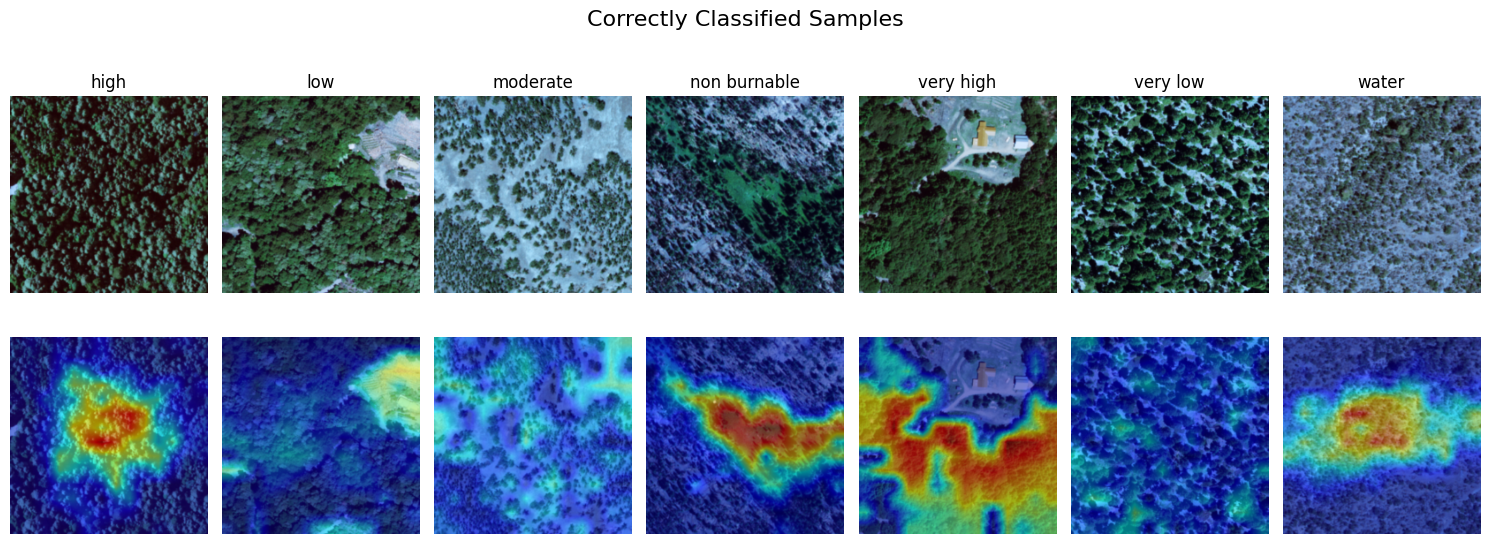

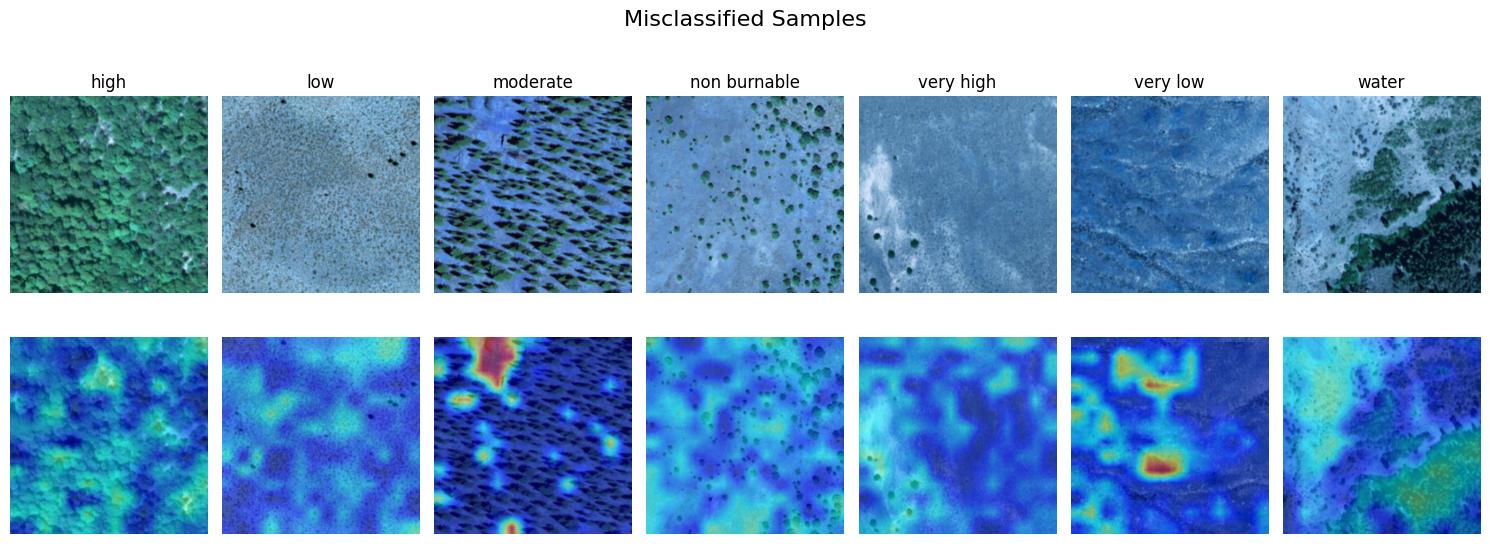

In [ ]:
# Visualize Grad-CAM heatmaps
visualize_cam_correct_incorrect(vit_firerisk, cam, val_loader, device, classes)

**TSNE plot**

In [ ]:
# Assuming vit_firerisk is the ViT model you loaded
model = vit_firerisk
model.eval()  # Set the model to evaluation mode


# Assuming `val_loader` is your validation data loader
all_features = []  # To store the extracted features
all_labels = []    # To store the corresponding labels

# Loop through the validation data loader
with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in val_loader:
        images = images.to(device)  # Move images to the device
        labels = labels.to(device)  # Move labels to the device

        # Extract features using forward_features (skip the final classification head)
        features = model.forward_features(images)

        # Optionally average the features across the sequence (tokens) to get a single vector per image
        pooled_features = features.mean(dim=1)  # Shape: [batch_size, embedding_dim]

        # Append features and labels
        all_features.append(pooled_features.cpu().numpy())  # Move features to CPU and convert to numpy
        all_labels.append(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

In [ ]:
# Convert all features and labels to numpy arrays for easier manipulation
all_features_concat = np.concatenate(all_features, axis=0)
all_labels_concat = np.concatenate(all_labels, axis=0)

# Apply t-SNE to reduce the features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=1000,n_iter=1000)
tsne_results = tsne.fit_transform(all_features_concat )

/tmp/ipykernel_30/1159356507.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=all_labels_concat, cmap=plt.cm.get_cmap('jet', len(class_names)),


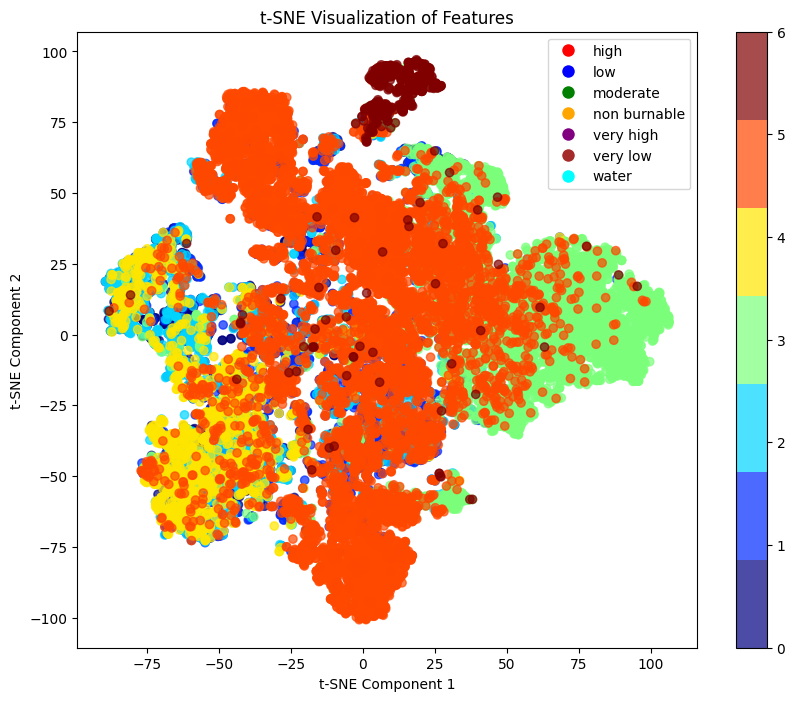

In [ ]:
class_names = ["high", "low", "moderate", "non burnable", "very high", "very low", "water"]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']

# Create a scatter plot with colors corresponding to the class labels
plt.figure(figsize=(10, 8))

# Scatter points, color by labels
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=all_labels_concat, cmap=plt.cm.get_cmap('jet', len(class_names)),
                      alpha=0.7)

# Add a legend with class names and colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=class_names[i],
                            markersize=10, markerfacecolor=colors[i]) for i in range(len(class_names))]
plt.legend(handles=legend_labels, loc='upper right')

# Add color bar for labels
plt.colorbar(scatter, ticks=np.arange(len(class_names)))

# Set plot title and labels
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

/tmp/ipykernel_30/3522806688.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='jet', alpha=0.7)


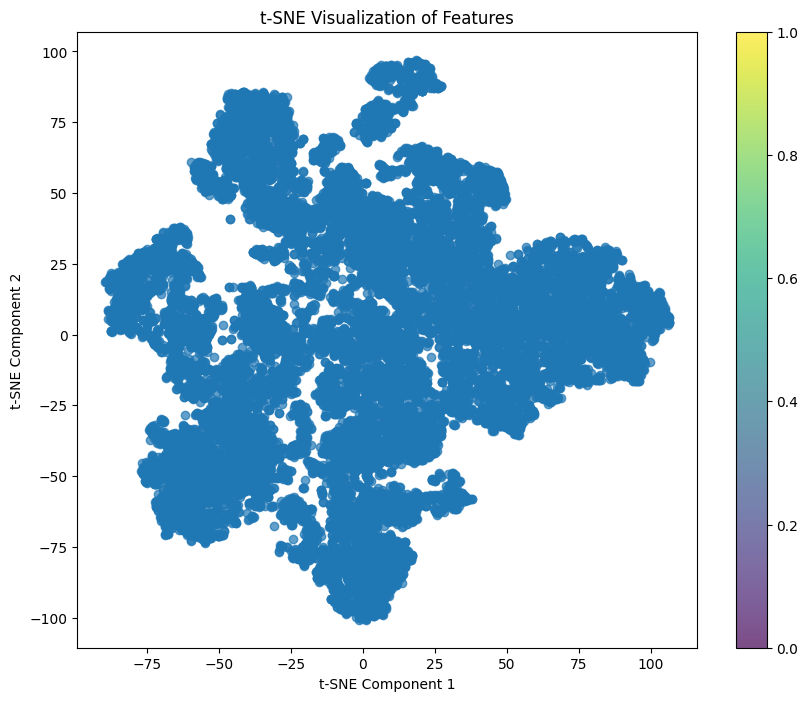

In [ ]:

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels_concat, cmap='jet', alpha=0.7)
plt.colorbar(scatter)  # Show color bar for labels
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### **Custom Model**

In [ ]:
# Freeze the ViTMAE model parameters
for param in vit_firerisk.parameters():
    param.requires_grad = False

In [ ]:
for name, param in viteuro.named_parameters():
    if "head" not in name:  # Freeze all layers except the head
        param.requires_grad = False
    else:
        print(f"Keeping requires_grad=True for: {name}")

In [ ]:
class EnsembleModel(torch.nn.Module):
    def __init__(self, vitmae, viteuro, num_classes):
        super(EnsembleModel, self).__init__()
        self.vitmae = vitmae
        self.viteuro = viteuro
        self.fc = torch.nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        logits_mae = self.vitmae(x)
        logits_euro = self.viteuro(x)
        combined_logits = logits_mae + logits_euro
        # combined_logits = torch.cat((logits_mae, logits_euro), dim=1)
        return combined_logits#self.fc(combined_logits)


In [ ]:
custom_model = EnsembleModel(vit_firerisk, viteuro, num_classes=7)
custom_model = nn.DataParallel(custom_model, device_ids=[0, 1]).to(device)

**Model summary and parameters**

In [ ]:
# # model summary
# print(custom_model)

In [ ]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in custom_model.parameters())  #numel returns the number of parameters in the model
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in custom_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

**Optimizer and Loss function**

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = Adam(custom_model.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=7, delta=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.1, verbose=True)

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_precision, train_recall, train_f1 = train(custom_model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc, valid_precision, valid_recall, valid_f1 = validate(custom_model, val_loader,  criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.3f}, Training acc: {train_epoch_acc:.3f},\
      Training precision: {train_precision:.3f}, Training recall: {train_recall:.3f}, Training f1: {train_f1:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, Validation acc: {valid_epoch_acc:.3f}, \
      Validation precision: {valid_precision:.3f}, Validation recall: {valid_recall:.3f}, Validation f1: {valid_f1:.3f}")
    print('-'*50)
    time.sleep(5)

    # Step the scheduler
    scheduler.step(valid_epoch_loss)

    # Check for early stopping
    early_stopping(valid_epoch_loss)
    if early_stopping.early_stop:
        print("[INFO]: Early stopping triggered.")
        break

    # Save the best model based on validation loss
    if valid_epoch_loss == early_stopping.best_loss:
        save_model(epoch+1, custom_model, optimizer, criterion)


print('TRAINING COMPLETE')

In [ ]:
# print(f"Training loss: {train_epoch_loss:.3f}, Training acc: {train_epoch_acc:.3f},\
#       Training precision: {train_precision:.3f}, Training recall: {train_recall:.3f}, Training f1: {train_f1:.3f}")


**Save the model**

In [ ]:
# save the trained model weights
#save_model(epochs, custom_model, optimizer, criterion)